# ML lab 08  
# Random Forest and Ensambles             

In [1]:
# Uncomment to upgrade packages
# !pip install pandas --upgrade --user --quiet
# !pip install numpy --upgrade --user --quiet
# !pip install scipy --upgrade --user --quiet
# !pip install statsmodels --upgrade --user --quiet
# !pip install scikit-learn --upgrade --user --quiet
# !pip install seaborn --upgrade --user --quiet
# !pip install imblearn --upgrade  --user
%load_ext autoreload

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
pd.set_option('precision', 3)
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# Extra imports
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix,\
        accuracy_score, classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,GradientBoostingClassifier,StackingClassifier,ExtraTreesClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.naive_bayes import GaussianNB

from time import time
from datetime import timedelta

import seaborn as sns
from matplotlib import pyplot as plt

sns.set()

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
def confusion(true, pred):
    """
    Function for pretty printing confusion matrices
    """
    pred = pd.Series(pred)
    true = pd.Series(true)
    
    true.name = 'target'
    pred.name = 'predicted'
    cm = pd.crosstab(true.reset_index(drop=True), pred.reset_index(drop=True))
    cm = cm[cm.index]
    return cm

In [6]:
np.random.seed(6046)

## SECTION 1: Financial Example

We are going to work with a dataset of direct marketing campaigns (phone calls) of a Portuguese banking institution. 

The classification goal is to predict wheather the client will subscribe a term deposit.

In [7]:
deposit = read_csv("bank-full.csv.gz", header=0, delimiter=';')

categorical_columns = [
    'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
    'month', 'poutcome'
]
deposit[categorical_columns] = deposit[categorical_columns].astype('category')

deposit.shape

(45211, 17)

In [8]:
deposit.describe(include='all')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,45211.000,45211,45211,45211,45211,45211.000,45211,45211,45211,45211.000,45211,45211.000,45211.000,45211.000,45211.000,45211,45211
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,NaN,4,2
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown,no
freq,NaN,9732,27214,23202,44396,NaN,25130,37967,29285,NaN,13766,NaN,NaN,NaN,NaN,36959,39922
mean,40.936,NaN,NaN,NaN,NaN,1362.272,NaN,NaN,NaN,15.806,NaN,258.163,2.764,40.198,0.580,NaN,NaN
std,10.619,NaN,NaN,NaN,NaN,3044.766,NaN,NaN,NaN,8.322,NaN,257.528,3.098,100.129,2.303,NaN,NaN
min,18.000,NaN,NaN,NaN,NaN,-8019.000,NaN,NaN,NaN,1.000,NaN,0.000,1.000,-1.000,0.000,NaN,NaN
25%,33.000,NaN,NaN,NaN,NaN,72.000,NaN,NaN,NaN,8.000,NaN,103.000,1.000,-1.000,0.000,NaN,NaN
50%,39.000,NaN,NaN,NaN,NaN,448.000,NaN,NaN,NaN,16.000,NaN,180.000,2.000,-1.000,0.000,NaN,NaN
75%,48.000,NaN,NaN,NaN,NaN,1428.000,NaN,NaN,NaN,21.000,NaN,319.000,3.000,-1.000,0.000,NaN,NaN


## Fast data analysis

Let's see how our data looks before we start working on it

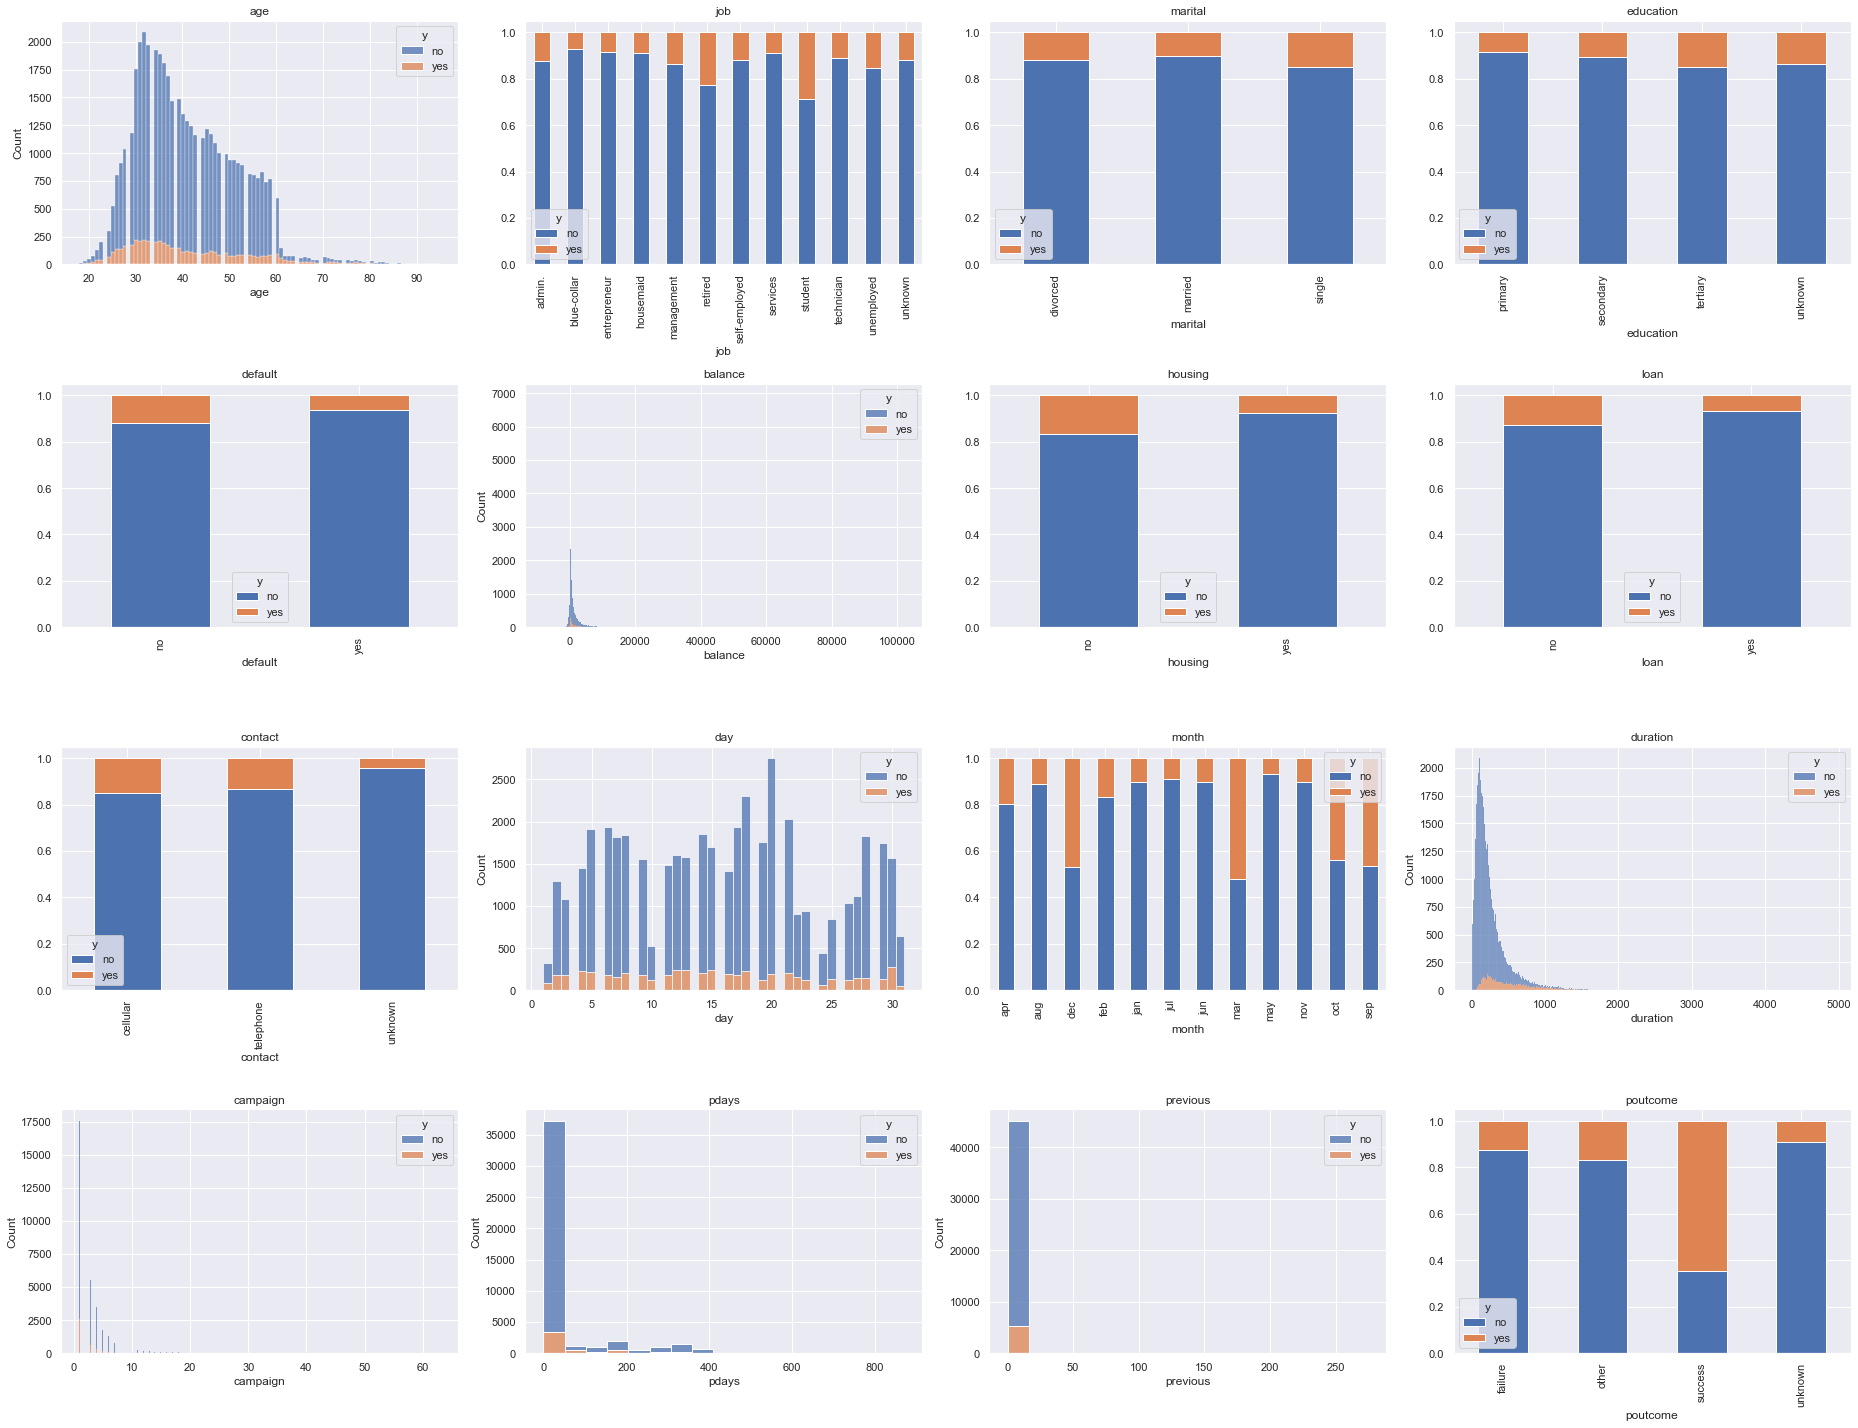

In [9]:
fig, axes = plt.subplots(4,4,figsize=(26,20))

for i, c in enumerate(deposit.columns):
    if c =='y':
        continue
    ax = axes.reshape(-1)[i]
    if deposit[c].dtype.kind == 'O':
        ct = pd.crosstab(index=deposit[c], columns=deposit['y'],normalize='index')
        a = ct.plot(kind='bar', stacked=True,ax=ax)  
    else:
        b = sns.histplot(x=c,hue='y',data=deposit,multiple='stack',ax=ax)
    t = ax.set_title(c)
plt.tight_layout()

This dataset needs a lot of pre-processing ... and it also displays a good mixture of categorical and numeric variables.

We have many categorical variables. If some categories are under-represented that might be a problem for our model.  Let's check whether this is the case. 

The `job` looks ok:

In [10]:
deposit.job.value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

The variable `education` has 4 values, let's check their frequency... it seems OK

In [11]:
deposit.education.value_counts()

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

`month` looks very suspicious ... but is OK

In [12]:
deposit.month.value_counts()

may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: month, dtype: int64

Now the numerical variables: Duration is highly skewed ...

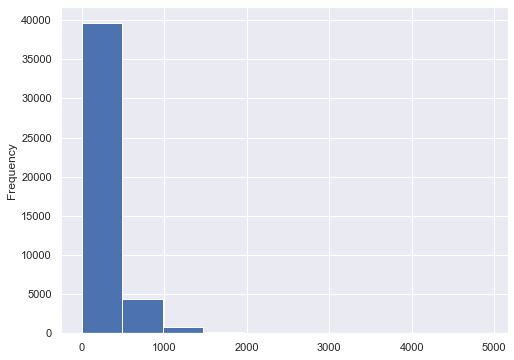

In [13]:
deposit.duration.plot.hist(figsize=(8,6));

We can avoid this that applying a logarithm to this column, as all values are positive. 

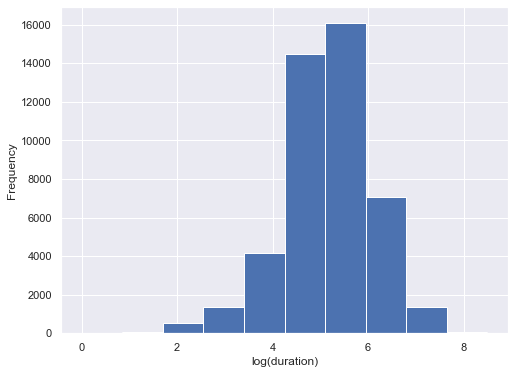

In [14]:
pd.set_option('use_inf_as_na', True)
ax = deposit.duration.apply('log').dropna().plot.hist(figsize=(8,6))
plt.xlabel('log(duration)');

Much better! We will use the log transformation on this variable.

In [15]:
deposit['duration'] = deposit.duration.apply(lambda x: np.log(x+0.001))

The variable `previous` has a bit of strange shape. It looks like it has a lot of 0 values.

<AxesSubplot:xlabel='previous', ylabel='Count'>

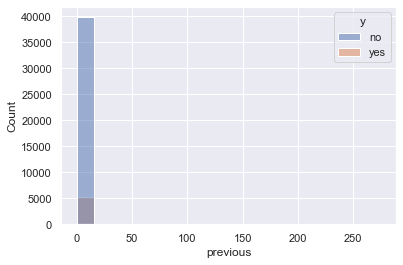

In [16]:
sns.histplot(x='previous',hue='y',data=deposit)

And with a lot we mean more than an eighty percent. We will use this knowledge to make a new discrete feature from this one.

In [17]:
(deposit['previous']==0).sum()/deposit.shape[0]

0.8173674548229414

In [18]:
deposit['previous_discrete']= deposit['previous'].apply(lambda x: '0' if x==0 else '>0' )

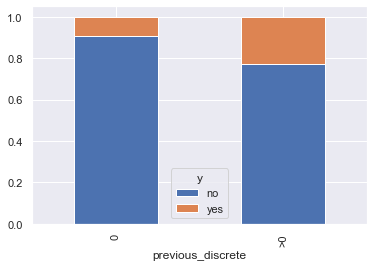

In [19]:
ct = pd.crosstab(index=deposit['previous_discrete'], columns=deposit['y'],normalize='index')
a = ct.plot(kind='bar', stacked=True) 

What should we do with `pdays` and `previous`? It is not clear how to best pre-process them; we shall need some financial expertise ... so we leave them as they are

The rest of variables seem OK (but it would take a careful analysis, and a lot of domain knowledge)

Let's rename the target ...

In [20]:
deposit.rename({'y':'subscribe'}, axis='columns',inplace=True)
deposit.shape

(45211, 18)

In [21]:
deposit.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribe,previous_discrete
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,5.565,1,-1,0,unknown,no,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,5.017,1,-1,0,unknown,no,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,4.331,1,-1,0,unknown,no,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,4.522,1,-1,0,unknown,no,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,5.288,1,-1,0,unknown,no,0


Scikit learn decision trees classifier do not handle categorical attributes so we have to transform them to numerical. 

We are going to transform the categorical columns using onehot-encoding; if there are not too many levels this may work well, but in general when doing this one should pay close attention to variable semantics, trying to reduce the number of levels in an ad-hoc way, etc.

### Preprocessing and resampling protocol
Now that we know our data, let's put all this in a preprocessing function.

This time we are going to split our data into train, test and validation. We can chose this protocol because we have a lot of samples. 

In [22]:
def preprocessing(X, y):
    # Apply log to duration so it looks less skewed
    X.loc[:, 'duration'] = X.loc[:,
                                 'duration'].apply(lambda x: np.log(x + 0.001))

    # Make our new derivated column from previous
    X['previous_discrete'] = X['previous'].apply(lambda x: '0'
                                                 if x == 0 else '>0')

    # Transform categorical variables into numbers because we are working with decision trees
    for column in X.columns:
        if X[column].dtype.kind == 'O':
            X_one_hot = pd.get_dummies(X[column], prefix=column)
            X = X.merge(X_one_hot,left_index=True,right_index=True)
            X = X.drop(columns=[column])
            
    X = X.dropna()
    y = y[X.index]
    y = y.replace({'yes':1, 'no':0})
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    return X, y

For the train/val/test datasets we will choose **stratified partitions**; what this means is that we will keep the same proportion of yes/no examples in each partition. With imbalanced datasets this is important since a random partition may increase the imbalance if we are unlucky.

In [23]:
deposit = read_csv("bank-full.csv.gz", header=0, delimiter=';')
deposit.rename({'y':'subscribe'}, axis='columns',inplace=True)

X_train, X_test, y_train, y_test = train_test_split(deposit.loc[:,:'poutcome'], deposit.loc[:,'subscribe'],  
                                                    test_size=0.2, stratify=deposit.loc[:,'subscribe'], random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)

            
X_train, y_train = preprocessing(X_train, y_train)
X_val, y_val = preprocessing(X_val, y_val)
X_test, y_test = preprocessing(X_test, y_test)

X_train.shape, X_val.shape, X_test.shape, 

((27126, 53), (9042, 53), (9043, 53))

### Metrics 

We have a classification problem with a strong imbalance on the target class. This time we will asume equally important the missclassification errors for both classes. For this reason we are going to use the next metrics to evaluate our model:
* F1-score for class 1. 
* F1-score for class 0. 
* F1-score macro average. 
* Accuracy. (Just for checking, accuracy is not the best metric with imbalanced data)


In [25]:
def compute_metrics(y_true,y_pred):
    accuracy = accuracy_score(y_true,y_pred)
    f1_score_1 = f1_score(y_true,y_pred,average='binary',pos_label=1)
    f1_score_0 = f1_score(y_true,y_pred,average='binary',pos_label=0)
    f1_score_macro = f1_score(y_true,y_pred,average='macro')
    return [accuracy,f1_score_1,f1_score_0,f1_score_macro]
    
    

results = pd.DataFrame(columns=['Accuracy', 'F1-score (class 1)', 'F1-score (class 0)', 'F1-score (macro avg)'])

## Models of the Decision Tree family

### Decision tree

First try a standard decision tree. 

A Decision Tree predicts the target by learning simple decision rules. During the training it will split the data so it can learn these rules. This model is very fast to train and interpretable but it can overfit easily. 

Hyperparameters: 
* `criterion`: gini or entropy 
* `max_depth`: maximum depth of the tree. Controls complexity. 
* `min_samples_split`: minimum number of samples required to split an internal node. Controls complexity. 
* `min_samples_leaf`: inimum number of samples required to be at a leaf node. Controls complexity.

In [26]:
model_tree = DecisionTreeClassifier().fit(X_train, 
                                          y_train)


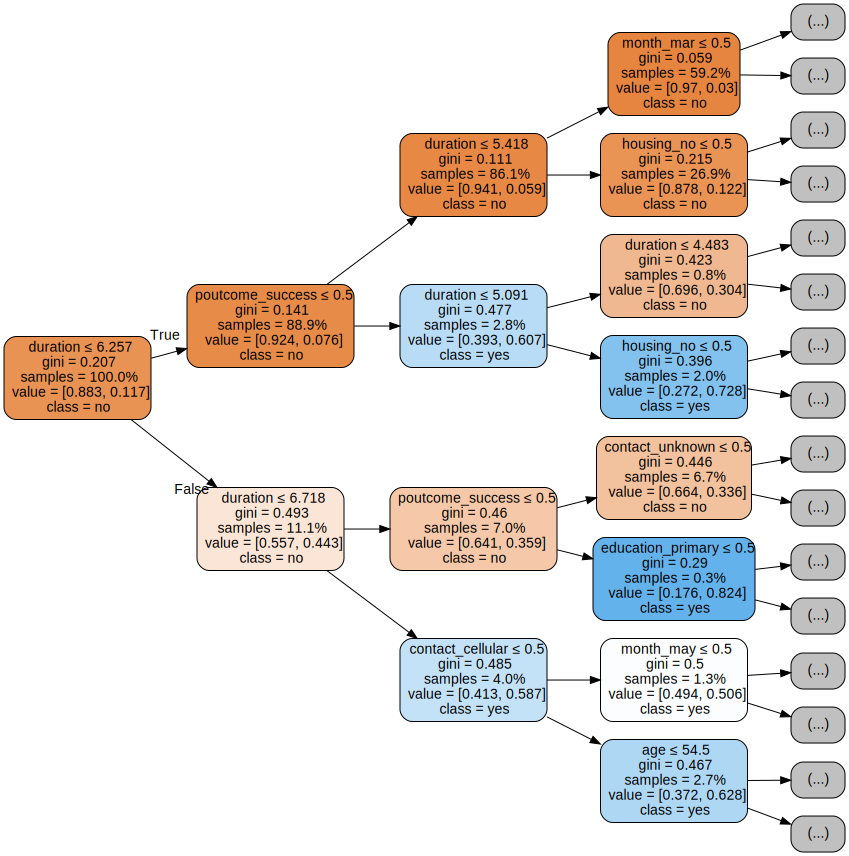

In [27]:
dot_data = export_graphviz(model_tree, out_file=None, 
                         feature_names=X_train.columns,  
                         class_names=['no', 'yes'],  
                         filled=True, rounded=True,  
                         special_characters=True, 
                         rotate=True,
                         proportion=True,
                         max_depth=3)  
graph = graphviz.Source(dot_data)  
graph 

Let's evaluate our first decision tree model. 

In [28]:
y_pred = model_tree.predict(X_val)

results.loc['DT-default',:] = compute_metrics(y_val, y_pred)

confusion(y_val, y_pred)

predicted,0,1
target,,
0,7385,599
1,555,503


We can use the detailed classification report to decide if we have chosen the best metrics for our problem. 

From the detailed report we can see that the classification for the class `yes` is not very good.

In [29]:
print(classification_report(y_val,
                            y_pred,
                            target_names=['no', 'yes'],))

results

              precision    recall  f1-score   support

          no       0.93      0.92      0.93      7984
         yes       0.46      0.48      0.47      1058

    accuracy                           0.87      9042
   macro avg       0.69      0.70      0.70      9042
weighted avg       0.87      0.87      0.87      9042



,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
DT-default,0.872,0.466,0.928,0.697


We can check if this model is overfitting by computing its train metrics and checking its complexity (is it a huge tree?)

As we can see on our results this model is able to predict the training data perfectly. It is possible that it has adapted to much to it, and because of that, we are obtaining those bad results on our validation partition.

In [30]:
y_pred_train = model_tree.predict(X_train)

confusion(y_train,y_pred_train)

print(classification_report(y_train,
                            y_pred_train,
                            target_names=['no', 'yes'],))

predicted,0,1
target,,
0,23953,0
1,0,3173


              precision    recall  f1-score   support

          no       1.00      1.00      1.00     23953
         yes       1.00      1.00      1.00      3173

    accuracy                           1.00     27126
   macro avg       1.00      1.00      1.00     27126
weighted avg       1.00      1.00      1.00     27126



If we check our classification tree we can see that the model with the default hyperparameters has generated a huge tree.

In [31]:
print('Tree depht: {}\nNodes: {}'.format(model_tree.tree_.max_depth, model_tree.tree_.node_count))

Tree depht: 35
Nodes: 4469


We can try to improve these results by optimizing its hyperparameters. We are going to use gridsearchcv from sklearn because its implementation is faster but we could just use our validation split to compare all the models. 

In [32]:
criterion = ['gini', 'entropy']
max_dephts = [None, 5, 10, 15, 20]
min_samples_split = [1, 2, 3, 4, 5]
min_samples_leaf = [1, 2, 3, 4, 5]
max_features = ['auto', 'sqrt', 'log2', None]

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

init_time = time()
model_tree = DecisionTreeClassifier()

f1_class_0_scorer = make_scorer(f1_score, pos_label=0)
f1_class_1_scorer = make_scorer(f1_score, pos_label=1)

scoring_dict = {
    'f1_mac': 'f1_macro',
    'f1_class_0': f1_class_0_scorer,
    'f1_class_1': f1_class_1_scorer,
    'acc': 'accuracy'
}

trc = GridSearchCV(estimator=model_tree,
                   scoring=scoring_dict,
                   param_grid={
                       'criterion': criterion,
                       'max_depth': max_dephts,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'max_features': max_features
                   },
                   cv=5,
                   return_train_score=False,
                   refit='f1_mac')

model_5CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

0:03:20.139919


In [33]:
scoring_cols = [
    'param_criterion', 'param_max_depth', 'param_max_features',
    'param_min_samples_leaf', 'param_min_samples_split', 'mean_test_f1_mac',
    'mean_test_f1_class_0', 'mean_test_f1_class_1', 'mean_test_acc'
]

pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',
                                                 ascending=False)[scoring_cols].head()

,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_f1_class_0,mean_test_f1_class_1,mean_test_acc
888,entropy,15,None,3,4,0.715,0.939,0.49,0.891
887,entropy,15,None,3,3,0.714,0.939,0.49,0.891
886,entropy,15,None,3,2,0.714,0.939,0.49,0.891
879,entropy,15,None,1,5,0.714,0.939,0.49,0.891
876,entropy,15,None,1,2,0.714,0.938,0.49,0.889


The best parameters we have found are 

In [34]:
best_params = model_5CV.best_params_
best_params

{'criterion': 'entropy',
 'max_depth': 15,
 'max_features': None,
 'min_samples_leaf': 3,
 'min_samples_split': 4}

We can use our validation metrics to save our best decision tree.

Our metrics show that the performance has improven a bit, but I would not trust my money on this prediction. Let's see if a more complex model can improve these results.

In [35]:
y_pred = model_5CV.predict(X_val)

results.loc['DT-best',:] = compute_metrics(y_val, y_pred)

confusion(y_val,y_pred)
results.sort_values(by='F1-score (macro avg)', ascending=False)

predicted,0,1
target,,
0,7629,355
1,580,478


,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
DT-best,0.897,0.506,0.942,0.724
DT-default,0.872,0.466,0.928,0.697


***

### Random Forests

Random Forest is an ensemble of Decision Trees; the idea is that by averaging high-variance but decorrelated individual decision trees we will avoid their tendency to overfitting. 

We also introduce the **Out-of-Bag** (OOB) error. This error is a metric that we can compute on Random Forest model while training. It is very very useful because it allows us to perform model selection (tune hyperparameters) without having to execute costly cross-validations.

While training, RF separates the data into subsets with replacement and trains the different trees of the forest with them. The OOB score is obtained by computing the accuracy of the trees on a set of samples that are not being used to train each specific tree. So, it acts as a **validation** score rather than a training one.


In [36]:
model_rf1 = RandomForestClassifier(oob_score=True).fit(X_train, y_train)

pred = model_rf1.predict(X_train)

confusion(y_train,pred)

print(classification_report(y_train,
                            pred,
                            target_names=['no', 'yes'],))

print('OOB accuracy=', model_rf1.oob_score_)

predicted,0,1
target,,
0,23953,0
1,0,3173


              precision    recall  f1-score   support

          no       1.00      1.00      1.00     23953
         yes       1.00      1.00      1.00      3173

    accuracy                           1.00     27126
   macro avg       1.00      1.00      1.00     27126
weighted avg       1.00      1.00      1.00     27126

OOB accuracy= 0.902049694020497


We can obtain an estimation of the validation accuaracy for free this way.  

let's compute the real validation error:

In [37]:
y_pred = model_rf1.predict(X_val)
print('Validation Accuracy:{}'.format(model_rf1.score(X_val,y_val)))
results.loc['RF-default',:] = compute_metrics(y_val,y_pred)
confusion(y_val,y_pred)

Validation Accuracy:0.904777704047777


predicted,0,1
target,,
0,7781,203
1,658,400


We can see that the OOB accuracy has estimated quite well the real validation one. 

Also, our Random Forest looks better than the DT, but it is far from perfect.

In [38]:
results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
DT-best,0.897,0.506,0.942,0.724
RF-default,0.905,0.482,0.948,0.715
DT-default,0.872,0.466,0.928,0.697


So OOB really works in estimating accuracy and the RF is better than a single tree; however, there is a big issue with the imbalance in our target class.

One way to deal with this is to include **class weights**

In [39]:
model_rf2 = RandomForestClassifier(n_estimators=100, 
                                   oob_score=True, 
                                   class_weight='balanced').fit(X_train, y_train)

pred = model_rf2.predict(X_train)

confusion(y_train, pred)

print(classification_report(y_train,pred,target_names=['no', 'yes'],))

print('OOB accuracy=', model_rf2.oob_score_)

predicted,0,1
target,,
0,23953,0
1,0,3173


              precision    recall  f1-score   support

          no       1.00      1.00      1.00     23953
         yes       1.00      1.00      1.00      3173

    accuracy                           1.00     27126
   macro avg       1.00      1.00      1.00     27126
weighted avg       1.00      1.00      1.00     27126

OOB accuracy= 0.9001327140013271


with a better balance; let's compute the real validation error:

In [40]:
y_pred = model_rf2.predict(X_val)

results.loc['RF-balance',:] = compute_metrics(y_val,y_pred)

confusion(y_val,y_pred)

predicted,0,1
target,,
0,7825,159
1,711,347


In [41]:
results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
DT-best,0.897,0.506,0.942,0.724
RF-default,0.905,0.482,0.948,0.715
DT-default,0.872,0.466,0.928,0.697
RF-balance,0.904,0.444,0.947,0.696


This is not helping a lot. Now there are two approaches that we could take: 
* We could try to handle the imbalance problem. 
* We could try to regularize our model, it has a clear overfitting problem.

We will try first tuning our model hyperparameters so it can handle better the overfitting.

Note that the parameter sets have been reduced to make the grid search faster on the lab.

In [42]:
init_time = time()

rf_model = RandomForestClassifier()

ntrees = [200,None]
max_depth = [100,None]
min_samples_split = [4,6]
min_samples_leaf = [4,6]
balance = [None, 'balanced', 'balanced_subsample']

trc = GridSearchCV(estimator=rf_model,
                   scoring=scoring_dict,
                   param_grid={
                       'n_estimators': ntrees,
                       'max_depth':max_depth,
                       'min_samples_split':min_samples_split,
                       'min_samples_leaf':min_samples_leaf, 
                       'class_weight':balance
                   },
                   cv=5,
                   return_train_score=False,
                   refit=False,
                   n_jobs=-1)

model_5CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

0:01:04.201023


In [43]:
scoring_cols = [
    'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split',
    'mean_test_f1_mac', 'mean_test_f1_class_0', 'mean_test_f1_class_1',
    'mean_test_acc'
]
pd.DataFrame(model_5CV.cv_results_).sort_values(
    by='mean_test_f1_mac', ascending=False)[scoring_cols].head()

,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_f1_class_0,mean_test_f1_class_1,mean_test_acc
42,None,4,6,0.770,0.933,0.607,0.886
16,100,4,4,0.770,0.933,0.606,0.886
34,100,4,6,0.769,0.933,0.605,0.885
18,100,4,6,0.768,0.933,0.604,0.885
40,None,4,4,0.768,0.933,0.603,0.885


Best parameters found: 

In [44]:
best_params = pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[['params']].iloc[0,0]
best_params

{'class_weight': 'balanced_subsample',
 'max_depth': None,
 'min_samples_leaf': 4,
 'min_samples_split': 6,
 'n_estimators': 200}

Let's refit our new model.

In [45]:
rf_model_tuned = RandomForestClassifier(**best_params)
rf_model_tuned.fit(X_train, y_train)

y_pred = rf_model_tuned.predict(X_val)

results.loc['RF-best', :] = compute_metrics(y_val, y_pred)

results.sort_values(by='F1-score (macro avg)', ascending=False)

RandomForestClassifier(class_weight='balanced_subsample', min_samples_leaf=4,
                       min_samples_split=6, n_estimators=200)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-best,0.885,0.612,0.932,0.772
DT-best,0.897,0.506,0.942,0.724
RF-default,0.905,0.482,0.948,0.715
DT-default,0.872,0.466,0.928,0.697
RF-balance,0.904,0.444,0.947,0.696


We can see on our results table that this approach has been quite successful. Improving up to 10 points on the minority F1 score. If we look at the validation confusion table, we notice the clear improvement on the minority class (still not perfect!)

In [46]:
confusion(y_val, y_pred)

predicted,0,1
target,,
0,7179,805
1,237,821


### Extra trees classifier

As we have seen, there is room for improvement. There is a model from the family of decision trees that we have not used: `Extra trees`. Essentially `extra trees` add randomization by choosing split-points at random (rather than trying out the best split as in random forests). This makes training them faster, and also more randomized.


In [47]:
extra_trees = ExtraTreesClassifier()
extra_trees.fit(X_train,y_train)

y_pred = extra_trees.predict(X_val)

results.loc['extra_trees',:] = compute_metrics(y_val,y_pred)

results.sort_values(by='F1-score (macro avg)', ascending=False)

ExtraTreesClassifier()

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-best,0.885,0.612,0.932,0.772
DT-best,0.897,0.506,0.942,0.724
RF-default,0.905,0.482,0.948,0.715
extra_trees,0.901,0.449,0.946,0.697
DT-default,0.872,0.466,0.928,0.697
RF-balance,0.904,0.444,0.947,0.696


In [48]:
init_time = time()

rf_model = ExtraTreesClassifier(class_weight='balanced')

ntrees = [150, None]
max_depth = [100, None]
min_samples_split = [4, 6]
min_samples_leaf = [2, 4]
balance = [None, 'balanced', 'balanced_subsample']

trc = GridSearchCV(estimator=rf_model,
                   scoring=scoring_dict,
                   param_grid={
                       'n_estimators': ntrees,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'class_weight': balance
                   },
                   cv=5,
                   return_train_score=True,
                   refit=False,
                   n_jobs=-1)

model_5CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

0:01:10.114668


In [49]:
pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[scoring_cols].head()

,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_f1_class_0,mean_test_f1_class_1,mean_test_acc
26,None,2,6,0.743,0.930,0.555,0.879
24,None,2,4,0.743,0.932,0.554,0.881
18,100,2,6,0.743,0.930,0.555,0.880
32,100,2,4,0.743,0.932,0.553,0.882
16,100,2,4,0.742,0.932,0.551,0.882


Best extra trees found: 

In [50]:
best_params = pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[['params']].iloc[0,0]
best_params

{'class_weight': 'balanced',
 'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 150}

In [51]:
extra_trees_best = ExtraTreesClassifier(**best_params)
extra_trees_best.fit(X_train,y_train)

y_pred = extra_trees_best.predict(X_val)

results.loc['extra_trees-best',:] = compute_metrics(y_val,y_pred)

results.sort_values(by='F1-score (macro avg)', ascending=False)

ExtraTreesClassifier(class_weight='balanced', min_samples_leaf=2,
                     min_samples_split=6, n_estimators=150)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-best,0.885,0.612,0.932,0.772
extra_trees-best,0.878,0.561,0.929,0.745
DT-best,0.897,0.506,0.942,0.724
RF-default,0.905,0.482,0.948,0.715
extra_trees,0.901,0.449,0.946,0.697
DT-default,0.872,0.466,0.928,0.697
RF-balance,0.904,0.444,0.947,0.696


### Feature importance 

One advantage that RF and DT have is that they perform feature selection on training. 

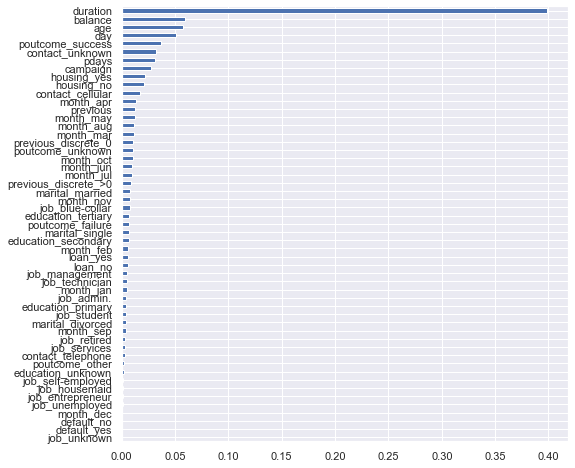

In [52]:
var_imp = pd.DataFrame({'importance': rf_model_tuned.feature_importances_},
                       index=X_train.columns)

var_imp.sort_values(by='importance').plot.barh(figsize=(8,8),
                                               legend=False);

according to our model, `duration` is the most important variable for predicting the target. 

## Ensembles

Now that we have a set of models we are going to combine them into more powerful classifiers. 

First we will take our simple classifiers + GaussianNB and make a voting classifier with them.

In [53]:
gauss_nb = GaussianNB()
gauss_nb.fit(X_train,y_train)

y_pred = gauss_nb.predict(X_val)

results.loc['GaussianNB-default',:] = compute_metrics(y_val,y_pred)

results.sort_values(by='F1-score (macro avg)', ascending=False)

GaussianNB()

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-best,0.885,0.612,0.932,0.772
extra_trees-best,0.878,0.561,0.929,0.745
DT-best,0.897,0.506,0.942,0.724
RF-default,0.905,0.482,0.948,0.715
extra_trees,0.901,0.449,0.946,0.697
DT-default,0.872,0.466,0.928,0.697
RF-balance,0.904,0.444,0.947,0.696
GaussianNB-default,0.83,0.411,0.901,0.656


With a voting classifier we can make the models vote in a "hard" fashion (majority vote) or "soft" fashion (averaging probabilities). 

In [54]:
voting_hard = VotingClassifier([('dt', model_tree), ('rf', model_rf1),
                                ('gnb', gauss_nb),('extratrees',extra_trees)])
voting_hard.fit(X_train, y_train)

y_pred = voting_hard.predict(X_val)

results.loc['voting_hard', :] = compute_metrics(y_val, y_pred)

results.loc[['DT-default','GaussianNB-default','RF-default','extra_trees','voting_hard'],:].sort_values(
    by='F1-score (class 1)',ascending=False)

VotingClassifier(estimators=[('dt', DecisionTreeClassifier()),
                             ('rf', RandomForestClassifier(oob_score=True)),
                             ('gnb', GaussianNB()),
                             ('extratrees', ExtraTreesClassifier())])

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-default,0.905,0.482,0.948,0.715
DT-default,0.872,0.466,0.928,0.697
extra_trees,0.901,0.449,0.946,0.697
voting_hard,0.904,0.426,0.947,0.687
GaussianNB-default,0.83,0.411,0.901,0.656


We can see that soft voting works better. We can also see that the models are performing better together. 

In [55]:
voting_soft = VotingClassifier([('dt', model_tree), ('rf', model_rf1),
                                ('gnb', gauss_nb),('extratrees',extra_trees)],voting='soft')
voting_soft.fit(X_train, y_train)

y_pred = voting_soft.predict(X_val)

results.loc['voting_soft', :] = compute_metrics(y_val, y_pred)

results.loc[['DT-default','GaussianNB-default','RF-default','extra_trees','voting_hard','voting_soft'],:].sort_values(
    by='F1-score (class 1)',ascending=False)

VotingClassifier(estimators=[('dt', DecisionTreeClassifier()),
                             ('rf', RandomForestClassifier(oob_score=True)),
                             ('gnb', GaussianNB()),
                             ('extratrees', ExtraTreesClassifier())],
                 voting='soft')

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
voting_soft,0.9,0.508,0.944,0.726
RF-default,0.905,0.482,0.948,0.715
DT-default,0.872,0.466,0.928,0.697
extra_trees,0.901,0.449,0.946,0.697
voting_hard,0.904,0.426,0.947,0.687
GaussianNB-default,0.83,0.411,0.901,0.656


Now we can make a voting classifier with our best models.

In [56]:
voting_best = VotingClassifier([('rf', rf_model_tuned),
                                ('extratrees',extra_trees_best)],voting='soft')
voting_best.fit(X_train, y_train)

y_pred = voting_best.predict(X_val)

results.loc['voting_best', :] = compute_metrics(y_val, y_pred)

results.loc[['RF-best','extra_trees-best','voting_best'],:].sort_values(by='F1-score (class 1)',ascending=False)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced_subsample',
                                                     min_samples_leaf=4,
                                                     min_samples_split=6,
                                                     n_estimators=200)),
                             ('extratrees',
                              ExtraTreesClassifier(class_weight='balanced',
                                                   min_samples_leaf=2,
                                                   min_samples_split=6,
                                                   n_estimators=150))],
                 voting='soft')

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-best,0.885,0.612,0.932,0.772
voting_best,0.886,0.6,0.934,0.767
extra_trees-best,0.878,0.561,0.929,0.745


Another ensamble we can use is an Stacking classifier. It will train another classifier on the top of the result of our classifiers instead of voting.

In [57]:
stacky = StackingClassifier(
    estimators=[('rf', rf_model_tuned), ('extratrees', extra_trees_best)],
    final_estimator=GradientBoostingClassifier())

stacky.fit(X_train, y_train)

y_pred = stacky.predict(X_val)

results.loc['stackyn-clf', :] = compute_metrics(y_val, y_pred)
results.loc[['RF-best','extra_trees-best','stackyn-clf'],:].sort_values(by='F1-score (class 1)',ascending=False)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(class_weight='balanced_subsample',
                                                       min_samples_leaf=4,
                                                       min_samples_split=6,
                                                       n_estimators=200)),
                               ('extratrees',
                                ExtraTreesClassifier(class_weight='balanced',
                                                     min_samples_leaf=2,
                                                     min_samples_split=6,
                                                     n_estimators=150))],
                   final_estimator=GradientBoostingClassifier())

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-best,0.885,0.612,0.932,0.772
extra_trees-best,0.878,0.561,0.929,0.745
stackyn-clf,0.907,0.546,0.948,0.747


## Our results

We have tried many many models and burnt lots of computing time. Let us check our results now. 

The best model we have trained according to our metrics is the voting soft classifier with the best random forest and extra trees. These two models follow on the ranking closely.

In [58]:
results.sort_values(by='F1-score (class 1)',ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-best,0.885,0.612,0.932,0.772
voting_best,0.886,0.6,0.934,0.767
extra_trees-best,0.878,0.561,0.929,0.745
stackyn-clf,0.907,0.546,0.948,0.747
voting_soft,0.9,0.508,0.944,0.726
DT-best,0.897,0.506,0.942,0.724
RF-default,0.905,0.482,0.948,0.715
DT-default,0.872,0.466,0.928,0.697
extra_trees,0.901,0.449,0.946,0.697
RF-balance,0.904,0.444,0.947,0.696


We can see that our best model after all that work is the tunned random forest. Now lets check our metrics over this model.

Our test results are very similar to the validation ones. Which means that our model would probably generalize well if we used it on new data.

We have scalated from a f1-score for class 1 of 0.473 in our first decision tree to a 0.61. Which is a great improvement given the difficulty of the problem.

In [59]:
y_pred = rf_model_tuned.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93      7985
           1       0.51      0.76      0.61      1058

    accuracy                           0.89      9043
   macro avg       0.74      0.83      0.77      9043
weighted avg       0.91      0.89      0.90      9043



In [60]:
confusion(y_test, y_pred)

predicted,0,1
target,,
0,7208,777
1,254,804
